In [3]:
# Load Dependecies

import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import pathlib
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/ML-Group-Project-Trim-main/ML-Group-Project-Trim-main')

In [6]:
categories = [f.name for f in os.scandir(path) if f.is_dir()]

print(categories)

['yt-downloads', 'soundcloud-downloads']


In [ ]:
# files = os.listdir( str(path) + '/*/*/wav/*' )
pattern = "*/wav/*"

files = list(pathlib.Path(path).glob(pattern))

random.shuffle(files)

print(files)

In [8]:
# Load features

file_path = str(path) + '/soundcloud-downloads/wav/mu00001.wav'
li_au, li_sr = librosa.load(file_path)
sc_sr, sc_au = wav.read(file_path)

print( 'Original SR: {}'.format( sc_sr ) )
print( 'Librosa SR: {}'.format( li_sr ) )
print( 'Original file min-max range: {} to {}'.format( np.min( sc_au ), np.max( sc_au ) ) )
print( 'Librosa file min-max range: {0:.2f} to {0:.2f}'.format( np.min( li_au ), np.max( li_au ) ) )

Original SR: 44100
Librosa SR: 22050
Original file min-max range: -30686 to 30333
Librosa file min-max range: -0.88 to -0.88


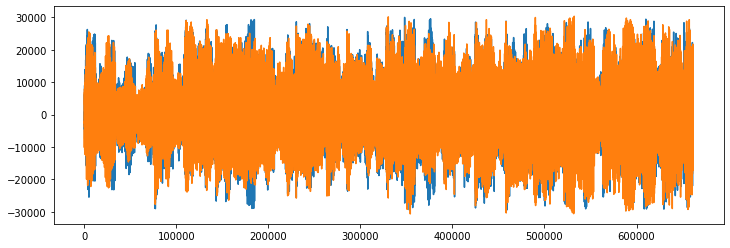

In [9]:
plt.figure( figsize=(12, 4) )
plt.plot( sc_au )
plt.savefig( 'og_au.png' )

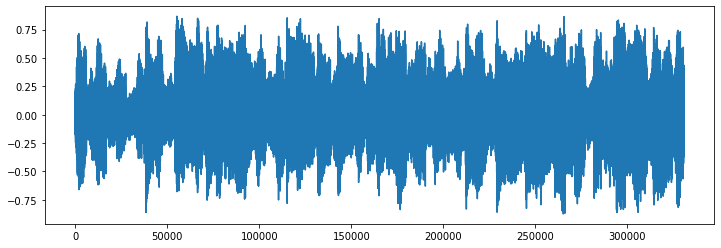

In [10]:
# Librosa: mono track.
plt.figure( figsize=(12,4) )
plt.plot( li_au )
plt.savefig( 'li_au.png' )

In [11]:
mfccs = librosa.feature.mfcc( y=li_au, sr=li_sr, n_mfcc = 40 )
print( mfccs.shape )

(40, 646)


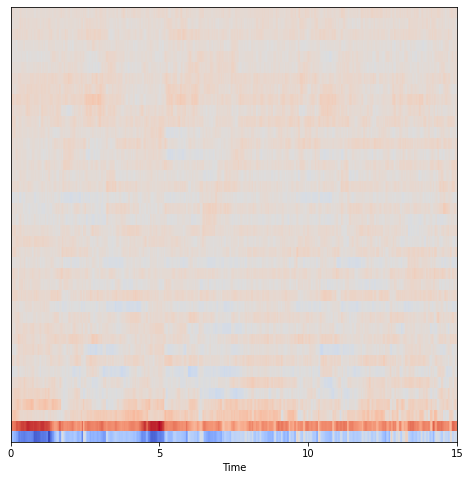

In [12]:
plt.figure( figsize=(8,8) )
librosa.display.specshow( mfccs, sr=li_sr, x_axis='time' )
plt.savefig( 'mfcc.png' )

In [13]:
def extract_features( file_name, class_label ):
    audio, sample_rate = librosa.load( file_name, res_type='kaiser_fast' )
    zcrs = librosa.feature.zero_crossing_rate( audio )
    mfccs = librosa.feature.mfcc( y=audio, sr=sample_rate, n_mfcc=40 )
    chromagram = librosa.feature.chroma_stft( audio, sr=sample_rate, hop_length=512 )
    rmse = librosa.feature.rms( y=audio )
    spec_cent = librosa.feature.spectral_centroid( y=audio, sr=sample_rate )
    spec_bw = librosa.feature.spectral_bandwidth( y=audio, sr=sample_rate )
    rolloff = librosa.feature.spectral_rolloff( y=audio, sr=sample_rate )
    features_processed = [ np.mean( zcrs ),np.mean( mfccs ),np.mean( chromagram ),
                         np.mean( rmse ),np.mean( spec_cent ),np.mean( spec_bw ),
                         np.mean( rolloff ), class_label ]

    return features_processed

In [14]:
speech_files = os.listdir( "/content/drive/MyDrive/Colab Notebooks/ML-Group-Project-Trim-main/ML-Group-Project-Trim-main/yt-downloads/wav/" )
sound_files = os.listdir( "/content/drive/MyDrive/Colab Notebooks/ML-Group-Project-Trim-main/ML-Group-Project-Trim-main/soundcloud-downloads/wav/" )

features = []

for file in speech_files:
    if file.endswith( ".wav" ) :
      class_label = 0 # speech
      data = extract_features( "/content/drive/MyDrive/Colab Notebooks/ML-Group-Project-Trim-main/ML-Group-Project-Trim-main/yt-downloads/wav/" + file, class_label )
      features.append( data )

for file in sound_files:
    if file.endswith( ".wav" ) :
      class_label = 1 # music
      data = extract_features( "/content/drive/MyDrive/Colab Notebooks/ML-Group-Project-Trim-main/ML-Group-Project-Trim-main/soundcloud-downloads/wav/" + file, class_label )
      features.append( data )

# Convert into a Panda dataframe.
featuresdf = pd.DataFrame( features, columns=[ 'zcrs', 'mfccs', 'chromagram', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'class_label' ] )

featuresdf.head()

,zcrs,mfccs,chromagram,rmse,spec_cent,spec_bw,rolloff,class_label
0,0.130065,-8.740104,0.376793,0.050187,2284.931950,1986.540801,4152.608223,0
1,0.116476,-7.222779,0.395206,0.064112,2149.595660,1881.208683,3934.326210,0
2,0.141413,-7.290301,0.387690,0.098992,2540.784886,2095.736303,4539.972547,0
3,0.097891,-7.137390,0.369581,0.074011,1819.815212,1718.981124,3321.563248,0
4,0.120004,-7.810161,0.405584,0.054381,2076.579681,1892.581596,3839.843448,0


In [15]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array( featuresdf.iloc[:,:-1], dtype = float )
y = np.array( featuresdf.class_label.tolist() )

print(X.shape)
print(X)

(205, 7)
[[ 1.30064973e-01 -8.74010372e+00  3.76792729e-01 ...  2.28493195e+03
   1.98654080e+03  4.15260822e+03]
 [ 1.16476242e-01 -7.22277880e+00  3.95206124e-01 ...  2.14959566e+03
   1.88120868e+03  3.93432621e+03]
 [ 1.41413355e-01 -7.29030085e+00  3.87690067e-01 ...  2.54078489e+03
   2.09573630e+03  4.53997255e+03]
 ...
 [ 8.25792437e-02 -8.54784489e+00  4.45448190e-01 ...  1.89040205e+03
   2.15902333e+03  3.99952582e+03]
 [ 1.06606309e-01 -8.19869518e+00  4.73107815e-01 ...  2.19984495e+03
   2.37186610e+03  4.80728760e+03]
 [ 8.97386864e-02 -8.08599281e+00  4.62841153e-01 ...  2.00162266e+03
   2.24572201e+03  4.30167399e+03]]


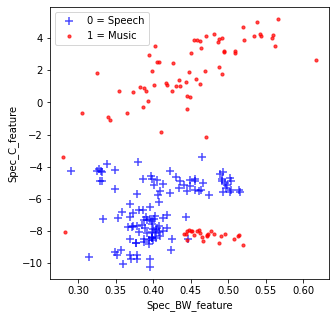

In [16]:
plt.subplots( figsize=(5, 5) )
plt.xlabel( 'Spec_BW_feature' )
plt.ylabel( 'Spec_C_feature' )

X1 = featuresdf.iloc[:,-6] # spec_bw
X2 = featuresdf.iloc[:,-7] # spec_cent

plt.scatter( X1[y==0], X2[y==0], c='blue', marker= '+', s=50, alpha=0.7, label='0 = Speech' )
plt.scatter( X1[y==1], X2[y==1], c='red', marker='o', s=10, alpha=0.7, label='1 = Music' )
plt.legend()

In [17]:
# split the dataset 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state = 127 )

In [18]:
# feature scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform( x_train )
X_test = sc.transform( x_test )

In [19]:
print( X_train )

[[-1.35489773 -0.84838955 -0.25168709 ... -1.86133791 -0.83231747
  -1.61882197]
 [ 0.98499492 -0.96021168 -0.04682675 ...  0.68511096 -0.68151843
  -0.09871287]
 [ 2.40055603 -0.80968023 -0.17070007 ...  1.43289252 -0.55792497
   0.23452021]
 ...
 [-0.4479273  -0.13284818  0.46760768 ... -0.58976882  0.24288928
  -0.14281251]
 [ 0.71881686 -1.1467219  -1.35612014 ...  0.47737719 -0.03872325
   0.13041926]
 [-0.38889951 -0.85166408  0.52879224 ... -0.77725257 -0.28366696
  -0.60525145]]


In [20]:
# Training the SVM model

from sklearn.svm import SVC

classifier = SVC()
classifier.fit( X_train, y_train )

SVC()

In [21]:
# Predicting the test results

y_pred = classifier.predict( X_test )

In [22]:
y_pred_train = classifier.predict(X_train)

In [23]:
# Making The Confusion Matrix

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test,y_pred)
print( "confusion matrix:" )
print( cm )

print( "train accuracy score:" )
print( accuracy_score( y_train, y_pred_train ) )
print( "test accuracy score:" )
# print( accuracy_score(  ) )

print( "model accuracy score:" )
print( accuracy_score( y_test, y_pred ) )

from sklearn.metrics import classification_report

print( "classification report:" )
print( classification_report( y_test, y_pred ) )

confusion matrix:
[[21  0]
 [ 2 18]]
train accuracy score:
0.975609756097561
test accuracy score:
model accuracy score:
0.9512195121951219
classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.90      0.95        20

    accuracy                           0.95        41
   macro avg       0.96      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41



In [24]:
# Baseline Predictor
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier( strategy="most_frequent" ).fit( X_train, y_train )

y_pred_dummy = dummy.predict( X_test )

print(y_pred_dummy)
print( "dummy confusion matrix:" )
print( confusion_matrix( y_test, y_pred_dummy ) )

print( "dummy classification report:" )
print( classification_report( y_test, y_pred_dummy ) )

accuracy_score( y_test, y_pred_dummy )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
dummy confusion matrix:
[[21  0]
 [20  0]]
dummy classification report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        21
           1       0.00      0.00      0.00        20

    accuracy                           0.51        41
   macro avg       0.26      0.50      0.34        41
weighted avg       0.26      0.51      0.35        41



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5121951219512195

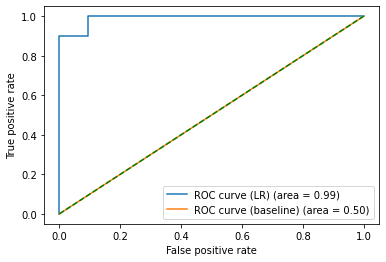

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# SVM ROC.
fpr, tpr, _ = roc_curve( y_test, classifier.decision_function( X_test ) )
roc_auc = auc( fpr, tpr )
plt.plot( fpr, tpr, label='ROC curve (LR) (area = %0.2f)' % roc_auc )

# Baseline ROC.
fpr_dummy, tpr_dummy, _dummy = roc_curve( y_test, y_pred_dummy )
roc_auc_dummy = auc( fpr_dummy, tpr_dummy )
plt.plot( fpr_dummy, tpr_dummy, label='ROC curve (baseline) (area = %0.2f)' % roc_auc_dummy )

plt.xlabel( "False positive rate" )
plt.ylabel( "True positive rate" )
plt.plot( [0, 1], [0, 1], color="green", linestyle="--" )
plt.legend()
plt.show()